In [79]:
from sklearn.datasets import fetch_covtype
import pandas as pd

# Load the dataset
covtype = fetch_covtype(as_frame=True)  # Returns a DataFrame
X = covtype.data  # Features
y = covtype.target - 1  # Target (adjusted to 0-6 for zero-based indexing)

In [80]:
sample_size = 20000
# Ensure we get a balanced sample across all classes
from sklearn.model_selection import train_test_split
X_sample, _, y_sample, _ = train_test_split(
    X, y, train_size=sample_size, random_state=42, stratify=y
)
X = X_sample
y = y_sample

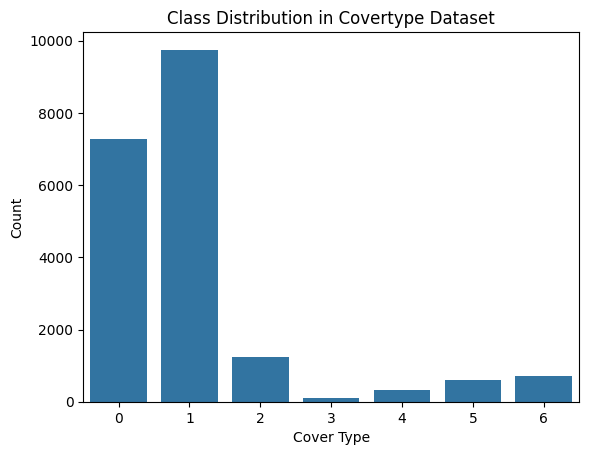

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=y)
plt.title('Class Distribution in Covertype Dataset')
plt.xlabel('Cover Type')
plt.ylabel('Count')
plt.show()

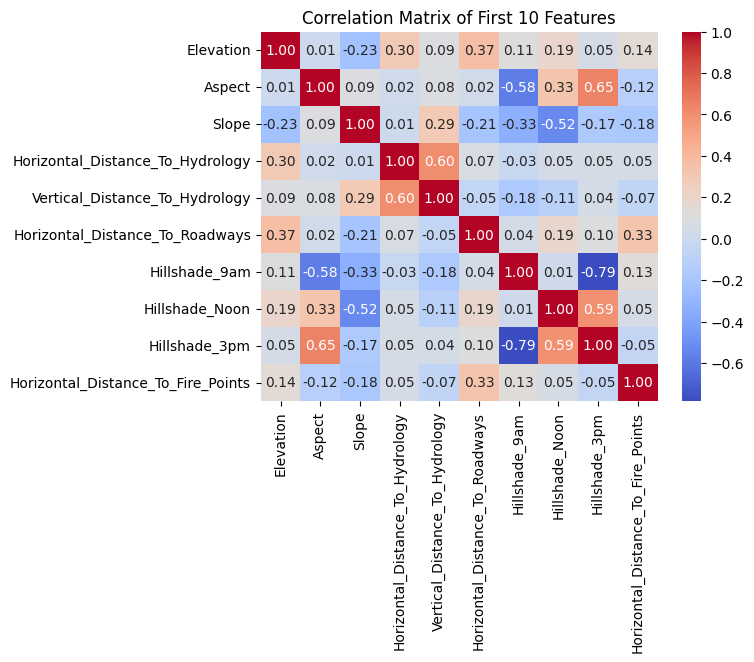

In [82]:
# Select first 10 features for simplicity
subset = X.iloc[:, :10]

# Compute correlation matrix
corr = subset.corr()

# Plot heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of First 10 Features')
plt.show()

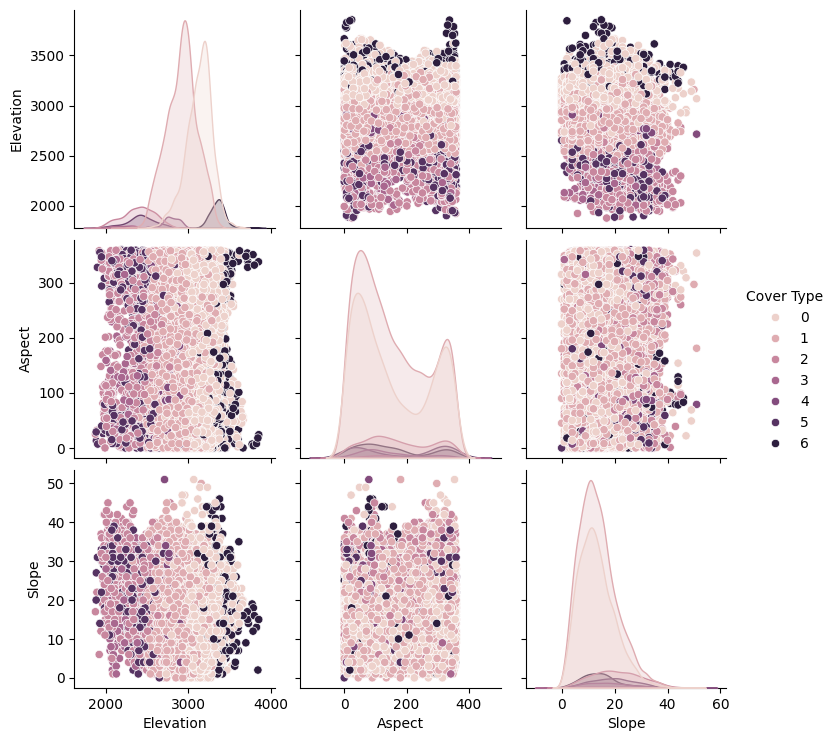

In [83]:
# Combine features and target for a sample
sample = X.iloc[:, :3].copy()  # First 3 features
sample['Cover Type'] = y

sns.pairplot(sample, hue='Cover Type', diag_kind='kde')
plt.show()

In [84]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split the dataset into training, validation and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Initialize the CatBoost model with default settings
model = CatBoostClassifier(verbose=0, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
baseline_accuracy = accuracy_score(y_test, y_pred)

print(f"Baseline Accuracy: {baseline_accuracy * 100:.2f}%")

Baseline Accuracy: 83.43%


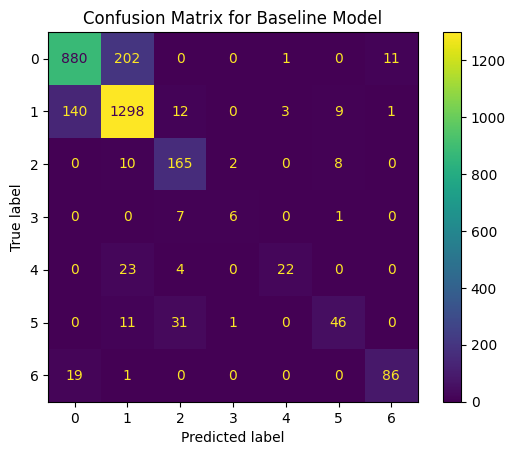

In [85]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
plt.title('Confusion Matrix for Baseline Model')
plt.show()

In [86]:
import catboost as cb
import numpy as np
from optuna.integration import CatBoostPruningCallback

In [87]:
import optuna
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 1),
        "depth": trial.suggest_int("depth", 1, 12),
        "eval_metric": "Accuracy",
    }

    # TODO: 
    # 1. Train CatBoost using params
    # 2. Return validation accuracy score as result
    # Area for improvement: use Cross-Validation instead of a single train/val split.
   

    gbm = cb.CatBoostClassifier(**params)

    pruning_callback = CatBoostPruningCallback(trial, "Accuracy")
    gbm.fit(
        X_train,
        y_train,
        eval_set=[(X_valid, y_valid)],
        verbose=0,
        early_stopping_rounds=100,
        callbacks=[pruning_callback],
    )

    # evoke pruning manually.
    pruning_callback.check_pruned()

    preds = gbm.predict(X_valid)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(y_valid, pred_labels)

    return accuracy


In [88]:
# Create the study
study_name = 'catboost_optimization1'
storage_name = 'sqlite:///example.db' 
study = optuna.create_study(
    study_name=study_name,
    storage=storage_name,
    direction='maximize',
    load_if_exists=True
)
study.optimize(objective, n_trials=20)  # Run 20 trials

[I 2025-04-03 11:08:37,162] A new study created in RDB with name: catboost_optimization1
C:\Users\jacek\AppData\Local\Temp\ipykernel_26344\1600564071.py:21: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, "Accuracy")
[I 2025-04-03 11:08:59,386] Trial 0 finished with value: 0.835 and parameters: {'iterations': 711, 'learning_rate': 0.47228864977914703, 'depth': 10}. Best is trial 0 with value: 0.835.
C:\Users\jacek\AppData\Local\Temp\ipykernel_26344\1600564071.py:21: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, "Accuracy")
[I 2025-04-03 11:12:33,394] Trial 1 finished with value: 0.842 and parameters: {'iterations': 771, 'learning_rate': 0.3211615658351381, 'depth': 12}. Best is trial 1 with value: 0.842.
C:\Users\jacek\AppData\L

In [89]:
# Retrieve the best trial from the study
best_trial = study.best_trial

print(f"Best Trial Number: {best_trial.number}")
print(f"Best Validation Accuracy: {best_trial.value:.4f}")
print("Best Hyperparameters Found:")
for key, value in best_trial.params.items():
    print(f"  {key}: {value}")

Best Trial Number: 10
Best Validation Accuracy: 0.8427
Best Hyperparameters Found:
  iterations: 992
  learning_rate: 0.35267163087515285
  depth: 12


In [90]:
best_params = best_trial.params

# --- IMPORTANT: Combine Training and Validation Data ---
# Create the full training dataset (train + validation) for the final model
X_train_full = pd.concat([X_train, X_valid], ignore_index=True)
y_train_full = pd.concat([y_train, y_valid], ignore_index=True)

final_params = best_params.copy()
final_params['random_state'] = 42

final_model = CatBoostClassifier(**final_params)
final_model.fit(X_train_full, y_train_full)

0:	learn: 1.2294469	total: 379ms	remaining: 6m 15s
1:	learn: 1.0261795	total: 795ms	remaining: 6m 33s
2:	learn: 0.8938177	total: 1.17s	remaining: 6m 26s
3:	learn: 0.8098045	total: 1.59s	remaining: 6m 31s
4:	learn: 0.7432726	total: 1.97s	remaining: 6m 29s
5:	learn: 0.6963049	total: 2.4s	remaining: 6m 34s
6:	learn: 0.6524389	total: 2.82s	remaining: 6m 37s
7:	learn: 0.6235251	total: 3.22s	remaining: 6m 36s
8:	learn: 0.5981959	total: 3.63s	remaining: 6m 37s
9:	learn: 0.5760310	total: 4.06s	remaining: 6m 39s
10:	learn: 0.5588420	total: 4.46s	remaining: 6m 38s
11:	learn: 0.5424582	total: 4.88s	remaining: 6m 38s
12:	learn: 0.5260754	total: 5.28s	remaining: 6m 37s
13:	learn: 0.5115815	total: 5.67s	remaining: 6m 36s
14:	learn: 0.5028894	total: 6.07s	remaining: 6m 35s
15:	learn: 0.4918053	total: 6.46s	remaining: 6m 33s
16:	learn: 0.4783954	total: 6.84s	remaining: 6m 32s
17:	learn: 0.4663705	total: 7.23s	remaining: 6m 31s
18:	learn: 0.4547636	total: 7.62s	remaining: 6m 30s
19:	learn: 0.4483965	to

--- Performance Comparison ---
Baseline Accuracy (on Test Set): 83.43%
Optimized Accuracy (on Test Set): 85.57%
Improvement due to HPO: 2.13%
Confusion Matrix for Final Optimized Model (on Test Set):


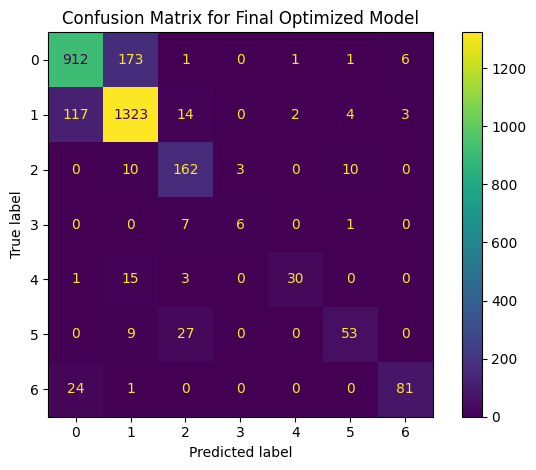

In [91]:
y_pred_test = final_model.predict(X_test)

# Calculate final accuracy
final_accuracy = accuracy_score(y_test, y_pred_test)

print("--- Performance Comparison ---")
# Assuming baseline_accuracy variable holds the score from Step 5
print(f"Baseline Accuracy (on Test Set): {baseline_accuracy * 100:.2f}%")
print(f"Optimized Accuracy (on Test Set): {final_accuracy * 100:.2f}%")
improvement = final_accuracy - baseline_accuracy
print(f"Improvement due to HPO: {improvement * 100:.2f}%")

print("Confusion Matrix for Final Optimized Model (on Test Set):")
ConfusionMatrixDisplay.from_estimator(final_model, X_test, y_test)
plt.title('Confusion Matrix for Final Optimized Model')
plt.tight_layout()
plt.show()

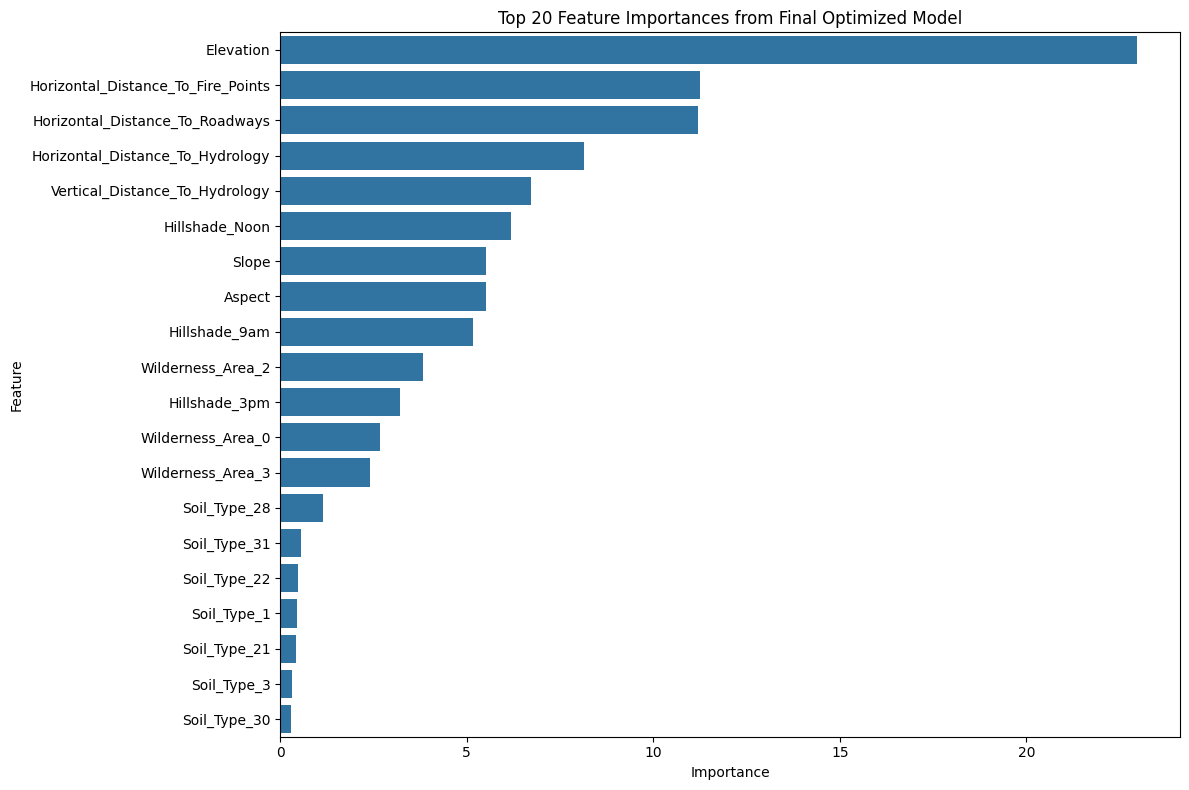

In [92]:
importances = final_model.get_feature_importance()
feature_names = X_train_full.columns

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances (e.g., top 20)
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20)) # Plot top 20
plt.title('Top 20 Feature Importances from Final Optimized Model')
plt.tight_layout()
plt.show()